SPREAD ANALYSIS OF BASKET AND ITS ITEMS

In [40]:
# Imports
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added project root to sys.path: {project_root}")


dashboard_path = os.path.join(project_root, 'dashboard')
if dashboard_path not in sys.path:
    sys.path.insert(0, dashboard_path) 
    print(f"Added dashboard directory to sys.path: {dashboard_path}")

try:
    
    from historical_data_loader import load_historical_data
    print("Successfully imported historical_data_loader.")
except ImportError as e:
    print(f"Error importing historical_data_loader: {e}")
    print(f"Attempted project root: {project_root}")
    print(f"Attempted dashboard path: {dashboard_path}")
    print(f"Current sys.path: {sys.path}")
    
    print("\nERROR: Could not import historical_data_loader.")
    print("Please ensure 'dashboard/historical_data_loader.py' exists and the paths above are correct.")
    
    raise


DATA_DIR = 'C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2'


if not os.path.isdir(DATA_DIR):
    print(f"ERROR: Data directory not found: {DATA_DIR}")
    print("Please verify the DATA_DIR path is correct.")
    


print(f"\nAttempting to load data from: {DATA_DIR}")

if 'load_historical_data' in globals():
    historical_data = load_historical_data(DATA_DIR)
else:
    print("ERROR: load_historical_data function not available.")
    historical_data = {} 

all_prices = []
if historical_data:
    print(f"\nLoaded data for days: {list(historical_data.keys())}")
    
    sorted_days = sorted(historical_data.keys())
    for day in sorted_days:
        day_data = historical_data[day]
        
        if 'prices' in day_data and isinstance(day_data['prices'], pd.DataFrame) and not day_data['prices'].empty:
            
            if 'day' not in day_data['prices'].columns:
                 day_data['prices']['day'] = day
                 print(f"  Manually added 'day' column for day {day}.")
            all_prices.append(day_data['prices'])
            print(f"  Appending prices for day {day}, shape: {day_data['prices'].shape}")
        else:
            print(f"  Warning: No valid price data found or loaded for day {day}.")

if all_prices:
    try:
        combined_prices_df = pd.concat(all_prices, ignore_index=True)
        print(f"\nSuccessfully combined price data.")
        print(f"Combined prices DataFrame shape: {combined_prices_df.shape}")
        print("\nCombined prices DataFrame head:")
        print(combined_prices_df.head())
        print("\nCombined prices DataFrame info:")
        combined_prices_df.info()
        
        print("\nUnique products in loaded data:")
        print(combined_prices_df['product'].unique())
        print("\nTimestamps range from:", combined_prices_df['timestamp'].min(), "to", combined_prices_df['timestamp'].max())
        print(f"\nData types:\n{combined_prices_df.dtypes}")

    except Exception as e:
        print(f"\nError during concatenation or initial analysis: {e}")
        combined_prices_df = pd.DataFrame() 
else:
    print("\nError: No price data could be loaded or combined. Cannot proceed.")
    combined_prices_df = pd.DataFrame() 

if combined_prices_df.empty:
    print("\nResult: combined_prices_df is empty. Check data loading steps and paths.")


Successfully imported historical_data_loader.

Attempting to load data from: C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2
Loading historical data for Round 2 from: C:/Users/Admin/projects/prosperity-poj/strategy/round2/resources/round2
  Loaded prices for day -1 from prices_round_2_day_-1.csv
  Loaded trades for day -1 from trades_round_2_day_-1_nn.csv
  Loaded prices for day 0 from prices_round_2_day_0.csv
  Loaded trades for day 0 from trades_round_2_day_0_nn.csv
  Loaded prices for day 1 from prices_round_2_day_1.csv
  Loaded trades for day 1 from trades_round_2_day_1_nn.csv

Loaded data for days: [-1, 0, 1]
  Appending prices for day -1, shape: (80000, 17)
  Appending prices for day 0, shape: (80000, 17)
  Appending prices for day 1, shape: (80000, 17)

Successfully combined price data.
Combined prices DataFrame shape: (240000, 17)

Combined prices DataFrame head:
   day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
0   -1         

In [41]:

if not combined_prices_df.empty:
    print("Pivoting the combined price data...")
    prices_pivot = combined_prices_df.pivot_table(
        index=['day', 'timestamp'],
        columns='product',
        values='mid_price' 
    )
    print(f"Pivot table created with shape: {prices_pivot.shape}")
    print(f"Pivot table columns: {prices_pivot.columns.tolist()}")

    
    print("Forward-filling missing values...")
    initial_na_counts = prices_pivot.isna().sum()
    prices_pivot.ffill(inplace=True)
    final_na_counts = prices_pivot.isna().sum()
    filled_counts = initial_na_counts - final_na_counts
    print(f"NaN values filled:\n{filled_counts[filled_counts > 0]}") 

    
    initial_rows = prices_pivot.shape[0]
    prices_pivot.dropna(inplace=True)
    print(f"Dropped {initial_rows - prices_pivot.shape[0]} rows with remaining NaNs after ffill.")

    
    basket1_components = {'CROISSANTS': 6, 'JAMS': 3, 'DJEMBES': 1}
    basket2_components = {'CROISSANTS': 4, 'JAMS': 2}

    # --- Calculate Synthetic Basket 1 ---
    required_cols_b1 = list(basket1_components.keys()) + ['PICNIC_BASKET1']
    if all(col in prices_pivot.columns for col in required_cols_b1):
        print("\nCalculating Synthetic Basket 1 and Spread...")
        prices_pivot['SYNTHETIC_BASKET1'] = 0
        for product, quantity in basket1_components.items():
            prices_pivot['SYNTHETIC_BASKET1'] += quantity * prices_pivot[product]

        # Calculate Spread 1
        prices_pivot['SPREAD_BASKET1'] = prices_pivot['PICNIC_BASKET1'] - prices_pivot['SYNTHETIC_BASKET1']
        print("-> Calculation for Basket 1 completed.")
    else:
        missing_cols = [col for col in required_cols_b1 if col not in prices_pivot.columns]
        print(f"\nWarning: Missing columns required for Basket 1 calculation: {missing_cols}. Skipping Basket 1.")
        if 'SPREAD_BASKET1' in prices_pivot.columns: prices_pivot.drop(columns=['SPREAD_BASKET1'], inplace=True) # Clean up if partially calculated
        if 'SYNTHETIC_BASKET1' in prices_pivot.columns: prices_pivot.drop(columns=['SYNTHETIC_BASKET1'], inplace=True)


    # --- Calculate Synthetic Basket 2 ---
    required_cols_b2 = list(basket2_components.keys()) + ['PICNIC_BASKET2']
    if all(col in prices_pivot.columns for col in required_cols_b2):
        print("\nCalculating Synthetic Basket 2 and Spread...")
        prices_pivot['SYNTHETIC_BASKET2'] = 0
        for product, quantity in basket2_components.items():
            prices_pivot['SYNTHETIC_BASKET2'] += quantity * prices_pivot[product]

        
        prices_pivot['SPREAD_BASKET2'] = prices_pivot['PICNIC_BASKET2'] - prices_pivot['SYNTHETIC_BASKET2']
        print("-> Calculation for Basket 2 completed.")
    else:
        missing_cols = [col for col in required_cols_b2 if col not in prices_pivot.columns]
        print(f"\nWarning: Missing columns required for Basket 2 calculation: {missing_cols}. Skipping Basket 2.")
        if 'SPREAD_BASKET2' in prices_pivot.columns: prices_pivot.drop(columns=['SPREAD_BASKET2'], inplace=True) # Clean up
        if 'SYNTHETIC_BASKET2' in prices_pivot.columns: prices_pivot.drop(columns=['SYNTHETIC_BASKET2'], inplace=True)

    # --- Display results ---
    print("\n--- Results ---")
    
    display_cols = [col for col in ['PICNIC_BASKET1', 'SYNTHETIC_BASKET1', 'SPREAD_BASKET1',
                                   'PICNIC_BASKET2', 'SYNTHETIC_BASKET2', 'SPREAD_BASKET2']
                    if col in prices_pivot.columns] # Only show columns that were actually calculated

    if display_cols:
        print("\nPivot table with calculated spreads (head):")
        print(prices_pivot[display_cols].head())
        print("\nPivot table with calculated spreads (tail):")
        print(prices_pivot[display_cols].tail())
        print("\nSpread statistics:")
        spread_cols = [col for col in display_cols if 'SPREAD' in col]
        if spread_cols:
             print(prices_pivot[spread_cols].describe())
        else:
             print("No spread columns were calculated.")
    else:
        print("\nCould not calculate any spreads due to missing columns or empty initial data.")

else:
    print("\ncombined_prices_df is empty. Skipping calculations.")
    prices_pivot = pd.DataFrame() # Ensure it exists as empty df


if prices_pivot.empty:
     print("\nResult: prices_pivot DataFrame is empty. Check previous steps.")

Pivoting the combined price data...
Pivot table created with shape: (30000, 8)
Pivot table columns: ['CROISSANTS', 'DJEMBES', 'JAMS', 'KELP', 'PICNIC_BASKET1', 'PICNIC_BASKET2', 'RAINFOREST_RESIN', 'SQUID_INK']
Forward-filling missing values...
NaN values filled:
Series([], dtype: int64)
Dropped 0 rows with remaining NaNs after ffill.

Calculating Synthetic Basket 1 and Spread...
-> Calculation for Basket 1 completed.

Calculating Synthetic Basket 2 and Spread...
-> Calculation for Basket 2 completed.

--- Results ---

Pivot table with calculated spreads (head):
product        PICNIC_BASKET1  SYNTHETIC_BASKET1  SPREAD_BASKET1  \
day timestamp                                                      
-1  0                 59289.0            59289.0             0.0   
    100               59287.0            59288.5            -1.5   
    200               59293.5            59290.5             3.0   
    300               59293.5            59293.0             0.5   
    400               5

Creating continuous timestamp...
Continuous timestamp created.
Plotting calculated spreads using continuous timestamp...


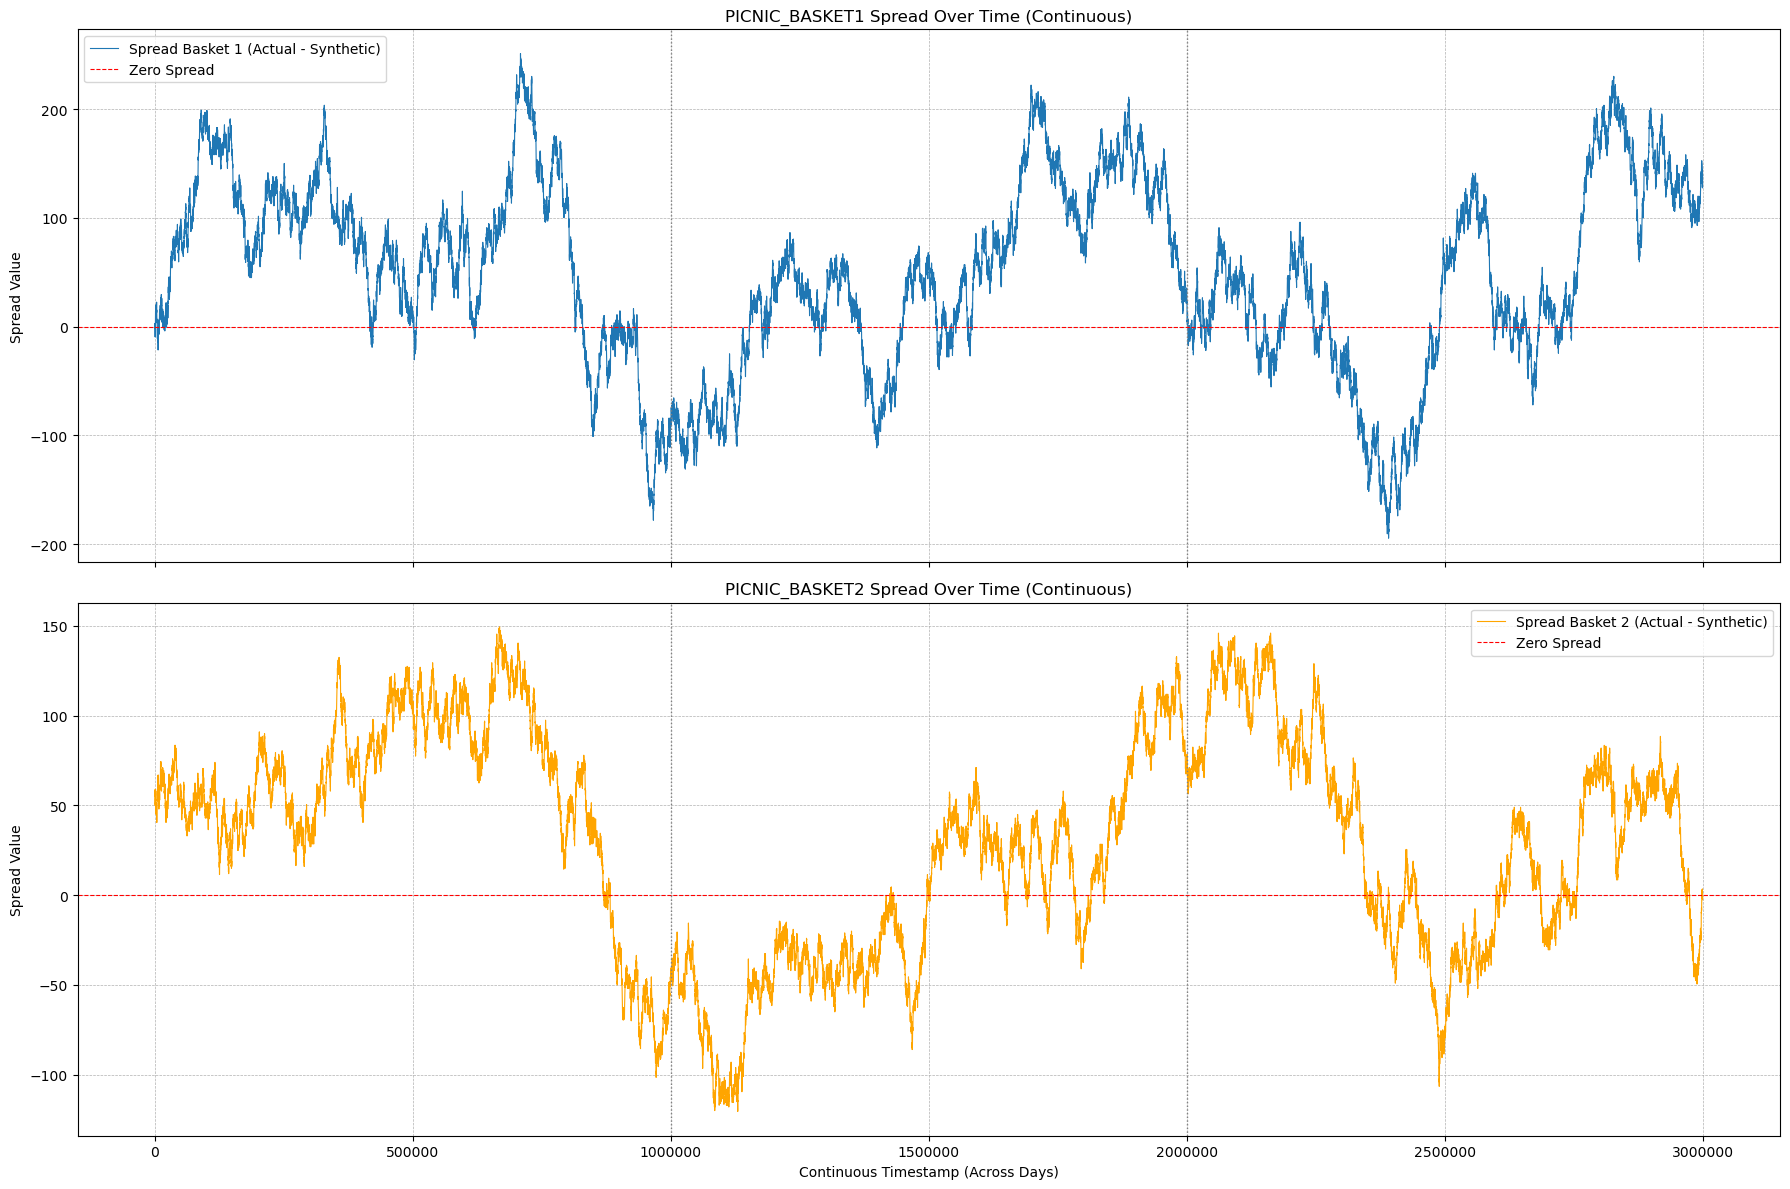

In [42]:



# Create a continuous timestamp across days for plotting

if 'prices_pivot' in globals() and not prices_pivot.empty:
    # Reset index if not already done, to access 'day' and 'timestamp' as columns
    if isinstance(prices_pivot.index, pd.MultiIndex):
        prices_pivot_reset = prices_pivot.reset_index()
    else:
        # If it's already reset or has a different index, ensure 'day' and 'timestamp' columns exist
        if 'day' not in prices_pivot.columns or 'timestamp' not in prices_pivot.columns:
             print("Error: 'day' or 'timestamp' columns missing after reset/pivot.")
             # Handle error appropriately, maybe try resetting again or stop
             prices_pivot_reset = pd.DataFrame() # Avoid further errors
        else:
             prices_pivot_reset = prices_pivot # Assume it's already suitable

    if not prices_pivot_reset.empty:
        print("Creating continuous timestamp...")
        # Calculate offset for each day. Max timestamp is 999900. Use 1,000,000 as interval.
        day_offset = {
            -1: 0,
            0: 1000000, # Offset for day 0
            1: 2000000  # Offset for day 1
        }
        prices_pivot_reset['continuous_timestamp'] = prices_pivot_reset.apply(
            lambda row: row['timestamp'] + day_offset.get(row['day'], 0),
            axis=1
        )
        print("Continuous timestamp created.")

        # --- Now plot using the continuous timestamp ---

        plot_spread1 = 'SPREAD_BASKET1' in prices_pivot_reset.columns
        plot_spread2 = 'SPREAD_BASKET2' in prices_pivot_reset.columns

        if plot_spread1 or plot_spread2:
            print("Plotting calculated spreads using continuous timestamp...")
            num_plots = sum([plot_spread1, plot_spread2])
            fig, axes = plt.subplots(num_plots, 1, figsize=(18, 6 * num_plots), sharex=True) # Increased width

            if num_plots == 1:
                axes = [axes]

            plot_index = 0

            # Plot Spread 1 if available
            if plot_spread1:
                ax = axes[plot_index]
                # Use continuous_timestamp for x-axis
                ax.plot(prices_pivot_reset['continuous_timestamp'], prices_pivot_reset['SPREAD_BASKET1'], label='Spread Basket 1 (Actual - Synthetic)', linewidth=0.8)
                ax.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero Spread')
                ax.set_title('PICNIC_BASKET1 Spread Over Time (Continuous)')
                ax.set_ylabel('Spread Value')
                ax.legend()
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                # Add vertical lines for day boundaries
                for day, offset in day_offset.items():
                     if day > -1: # Mark start of day 0 and day 1
                         ax.axvline(offset, color='gray', linestyle=':', linewidth=1)
                plot_index += 1

            # Plot Spread 2 if available
            if plot_spread2:
                ax = axes[plot_index]
                # Use continuous_timestamp for x-axis
                ax.plot(prices_pivot_reset['continuous_timestamp'], prices_pivot_reset['SPREAD_BASKET2'], label='Spread Basket 2 (Actual - Synthetic)', color='orange', linewidth=0.8)
                ax.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero Spread')
                ax.set_title('PICNIC_BASKET2 Spread Over Time (Continuous)')
                ax.set_ylabel('Spread Value')
                ax.legend()
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                 # Add vertical lines for day boundaries
                for day, offset in day_offset.items():
                     if day > -1: # Mark start of day 0 and day 1
                         ax.axvline(offset, color='gray', linestyle=':', linewidth=1)
                plot_index += 1

            # Common X axis label
            axes[-1].set_xlabel('Continuous Timestamp (Across Days)') # Label only the last plot's x-axis
            # Format x-axis ticks for readability if needed
            axes[-1].ticklabel_format(style='plain', axis='x')


            plt.tight_layout()
            plt.show()
        else:
            print("No spread columns available for plotting.")
    else:
        print("Failed to prepare prices_pivot_reset for plotting.")

else:
    print("prices_pivot DataFrame not found or is empty. Cannot plot spreads.")

MEAN REVERSION TEST FOR BASKET1

--- Analyzing Spread: SPREAD_BASKET2 ---

Plotting Rolling Mean & Standard Deviation...


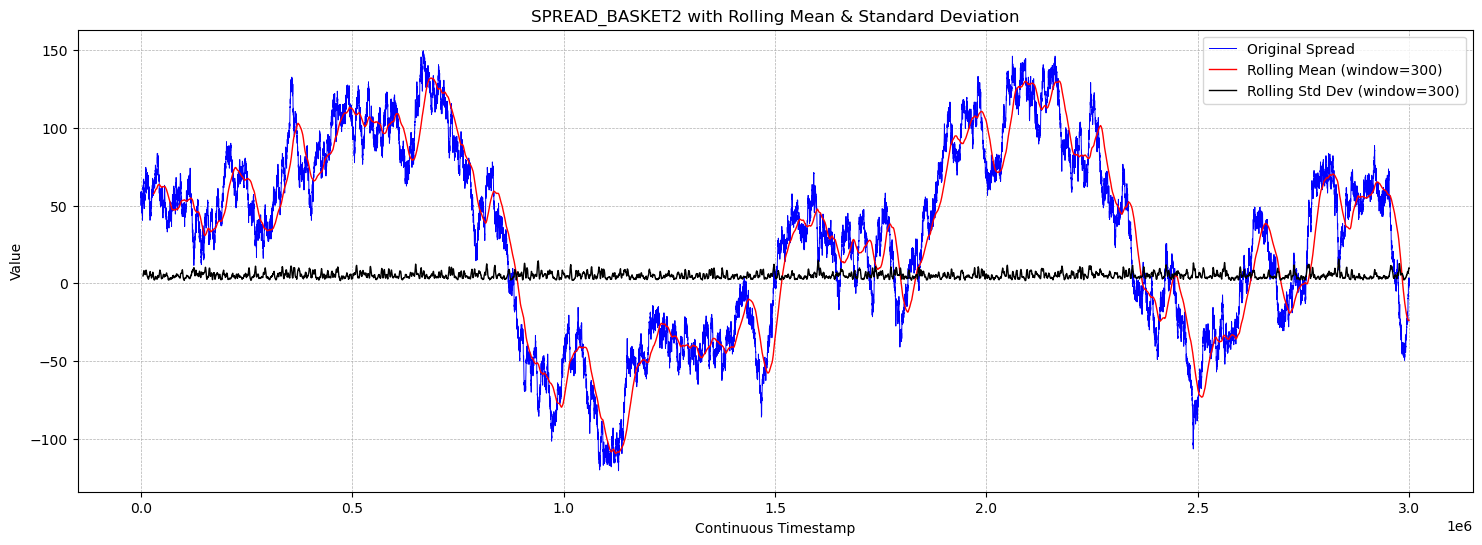


Checking 'SPREAD_BASKET2' data before ACF plot:
Shape of spread_data: (30000,)
Spread data description:
count    30000.000000
mean        30.235967
std         59.849200
min       -120.500000
25%        -22.000000
50%         38.500000
75%         75.000000
max        149.500000
Name: SPREAD_BASKET2, dtype: float64
Variance of spread_data: 3581.92676729115


In [46]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import warnings # To suppress potential warnings if variance is exactly zero

# --- Analysis: Check for Mean Reversion ---

# Choose the spread to analyze (change if needed)
spread_column = 'SPREAD_BASKET2' # Or 'SPREAD_BASKET2'

if 'prices_pivot_reset' in globals() and spread_column in prices_pivot_reset.columns:
    print(f"--- Analyzing Spread: {spread_column} ---")
    spread_data = prices_pivot_reset[spread_column].dropna() # Use data after dropping initial NaNs

    if not spread_data.empty:
        # 1. Visual Analysis: Rolling Statistics
        print("\nPlotting Rolling Mean & Standard Deviation...")
        window_size = max(100, len(spread_data) // 100)
        rolling_mean = spread_data.rolling(window=window_size).mean()
        rolling_std = spread_data.rolling(window=50).std()

        plt.figure(figsize=(18, 6))
        plt.plot(prices_pivot_reset.loc[spread_data.index, 'continuous_timestamp'], spread_data, label='Original Spread', color='blue', linewidth=0.7) # Use matching index for timestamp
        plt.plot(prices_pivot_reset.loc[spread_data.index, 'continuous_timestamp'], rolling_mean, label=f'Rolling Mean (window={window_size})', color='red', linewidth=1)
        plt.plot(prices_pivot_reset.loc[spread_data.index, 'continuous_timestamp'], rolling_std, label=f'Rolling Std Dev (window={window_size})', color='black', linewidth=1)
        plt.title(f'{spread_column} with Rolling Mean & Standard Deviation')
        plt.xlabel('Continuous Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

        # --- Check spread_data before ACF ---
        print(f"\nChecking '{spread_column}' data before ACF plot:")
        print(f"Shape of spread_data: {spread_data.shape}")
        print(f"Spread data description:\n{spread_data.describe()}")
        spread_variance = spread_data.var()
        print(f"Variance of spread_data: {spread_variance}")


    else:
        print(f"No data available in {spread_column} after dropping NaNs.")

elif 'prices_pivot_reset' not in globals():
     print("Error: prices_pivot_reset DataFrame not found. Run the previous cell.")
else:
    print(f"Error: Column '{spread_column}' not found in prices_pivot_reset.")


BASKET1 MEAN = 48.7 BASKET2 MEAN = 30.2